In [1]:
import numpy as np
import pandas as pd
import os
import joblib
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
test = pd.read_csv(
    os.path.join("future_sales", "test.csv"),
    dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'}
)
item_categories = pd.read_csv(
    os.path.join("future_sales", "item_categories.csv"),
    dtype={'item_category_name': 'str', 'item_category_id': 'int32'}
)
items = pd.read_csv(
    os.path.join("future_sales", "items.csv"),
    dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'}
)
shops = pd.read_csv(
    os.path.join("future_sales", "shops.csv"),
    dtype={'shop_name': 'str', 'shop_id': 'int32'}
)
sales = pd.read_csv(
    os.path.join("future_sales", "sales_train.csv"),
    parse_dates=['date'],
    dtype={
        'date': 'str',
        'date_block_num': 'int32',
        'shop_id': 'int32',
        'item_id': 'int32',
        'item_price': 'float32',
        'item_cnt_day': 'int32'
    }
)

# Merge sales with items, shops, and item_categories.
train = sales.join(items, on='item_id', rsuffix='_')\
                .join(shops, on='shop_id', rsuffix='_')\
                .join(item_categories, on='item_category_id', rsuffix='_')\
                .drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

print(f'Train rows: {train.shape[0]}')
print(f'Train columns: {train.shape[1]}')

train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
print(f"Min date from train set: {train['date'].min().date()}")
print(f"Max date from train set: {train['date'].max().date()}")

test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
train = train[train['shop_id'].isin(test_shop_ids)]
train = train[train['item_id'].isin(test_item_ids)]

train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
train_monthly = (train_monthly.sort_values('date')
                                .groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
                                .agg({'item_cnt_day': 'sum'}))
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')

train_monthly['item_cnt_month'] = (train_monthly.sort_values('date_block_num')
                                                    .groupby(['shop_id', 'item_id'])['item_cnt']
                                                    .shift(-1))

train_monthly['month'] = train_monthly['date_block_num'] % 12
train_monthly['year'] = (train_monthly['date_block_num'] // 12) + 2013

series = train_monthly.groupby('date_block_num')['item_cnt'].sum()

test_size = 0.3
split_idx = int(len(series) * (1 - test_size))
train_series = series.iloc[:split_idx]
val_series = series.iloc[split_idx:]

Train rows: 2935849
Train columns: 10
Min date from train set: 2013-01-01
Max date from train set: 2015-10-31


In [3]:
train_series

date_block_num
0     18033
1     18351
2     23553
3     18379
4     18534
5     19924
6     21172
7     24426
8     24031
9     24507
10    28461
11    45237
12    33624
13    33409
14    35592
15    29971
16    32189
17    35848
18    36367
19    43208
20    37197
21    41522
22    47147
Name: item_cnt, dtype: int32

In [4]:
series

date_block_num
0     18033
1     18351
2     23553
3     18379
4     18534
5     19924
6     21172
7     24426
8     24031
9     24507
10    28461
11    45237
12    33624
13    33409
14    35592
15    29971
16    32189
17    35848
18    36367
19    43208
20    37197
21    41522
22    47147
23    77532
24    54422
25    47306
26    47456
27    41484
28    41889
29    44879
30    46773
31    53560
32    48690
33    51060
Name: item_cnt, dtype: int32

In [5]:
df = series.reset_index()
df.columns = ['date_block_num', 'sales']

fig = px.line(df, 
              x='date_block_num', 
              y='sales', 
              title='Train Series Sales Over Time', 
              markers=True,
              labels={'date_block_num': 'Date Block Number', 'sales': 'Sales'})

fig.update_traces(mode='lines+markers', hovertemplate='Date Block: %{x}<br>Sales: %{y}')
fig.update_layout(hovermode='x unified')

fig.show()

In [7]:
def determine_differencing(series):
    """Determine differencing order d using ADF test"""
    d = 0
    p_value = adfuller(series)[1]
    
    while p_value > 0.05:
        d += 1
        series = np.diff(series)
        p_value = adfuller(series)[1]
        if d > 2:  # Prevent over-differencing
            break
    print(f"Suggested differencing order (d): {d}")
    return d

def plot_correlations(series, lags=10):
    """ACF and PACF for order selection"""
    plt.figure(figsize=(12, 6))
    
    # ACF Plot
    plt.subplot(211)
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    
    # PACF Plot
    plt.subplot(212)
    plot_pacf(series, lags=lags, ax=plt.gca(), method='ywm')
    plt.title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

def auto_select_arima_order(train_series, seasonal=False):
    """automatically select ARIMA orders"""
    print("Running automatic ARIMA order selection...")
    
    model = auto_arima(
        train_series,
        start_p=0, max_p=5,
        start_q=0, max_q=5,
        d=None,  
        seasonal=seasonal,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    
    print(f"Selected ARIMA order: {model.order}")
    return model.order

def manual_order_selection(train_series):
    """manual order selection"""
    d = determine_differencing(train_series)
    
    plot_correlations(train_series)

    series = np.diff(train_series)
    p_value = adfuller(series)[1]
    print(f"After differencing order (d): {d}, p_value : {p_value}")
    plot_correlations(series)    
    
    print("Manual Order Selection Guide:")
    print("1. Look at ACF/PACF plots:")
    print("   - PACF cuts off at lag p : AR(p)")
    print("   - ACF cuts off at lag q : MA(q)")
    print(f"2. Use d={d} based on ADF test")
    
    p = int(input("Enter AR order (p): "))
    q = int(input("Enter MA order (q): "))
    
    return (p, d, q)

def arima_analysis(train_series):
    adf_result = adfuller(train_series)
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    
    transformed, lam = boxcox(train_series)
    adf_result = adfuller(transformed)
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    
    return transformed, lam

def fit_arima(transformed_series, order):
    return ARIMA(transformed_series, order=order).fit()

def forecast_update(model, val_series, lam):
    """applies the Box-Cox transformation using lam to validation data."""
    forecasts = []
    actuals = []
    
    for t in range(len(val_series)):
        transformed_val = boxcox(val_series.iloc[t:t+1], lmbda=lam)[0]
        updated_model = model.append([transformed_val])
        
        # Forecast next step
        fc = updated_model.forecast(steps=1)
        forecasts.append(fc[0])
        actuals.append(val_series.iloc[t])
        model = updated_model
    
    return np.array(actuals), np.array(forecasts)

def inverse_transform(forecasts, lam):
    """revert Box-Cox transformation"""
    return np.exp(np.log(forecasts * lam + 1) / lam) if lam != 0 else np.exp(forecasts)

def visualize_results(actual, predicted):
    plt.figure(figsize=(15, 6))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(predicted, label='Predicted', marker='x', linestyle='--')
    plt.title('Validation Results')
    plt.xlabel('Time Step')
    plt.ylabel('Item Count')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_model(model, lam, path='arima_model.pkl'):
    joblib.dump({'model': model, 'lambda': lam}, path)
    print(f"Model saved to {path}")

def load_model(path='arima_model.pkl'):
    data = joblib.load(path)
    print(f"Model loaded from {path}")
    return data['model'], data['lambda']

In [8]:
df = val_series.reset_index()
df.columns = ['date_block_num', 'sales']

fig = px.line(df, 
              x='date_block_num', 
              y='sales', 
              title='Train Series Sales Over Time', 
              markers=True,
              labels={'date_block_num': 'Date Block Number', 'sales': 'Sales'})

fig.update_traces(mode='lines+markers', hovertemplate='Date Block: %{x}<br>Sales: %{y}')
fig.update_layout(hovermode='x unified')

fig.show()

ADF Statistic: -1.1243
p-value: 0.7053
ADF Statistic: -1.1562
p-value: 0.6921
Running automatic ARIMA order selection...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=65.413, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.824, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.933, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=64.667, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66.666, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec


/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' i

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=66.586, Time=0.01 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.331 seconds
Selected ARIMA order: (2, 1, 0)
Model saved to arima_model.pkl
Validation RMSE: 4370.92


/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



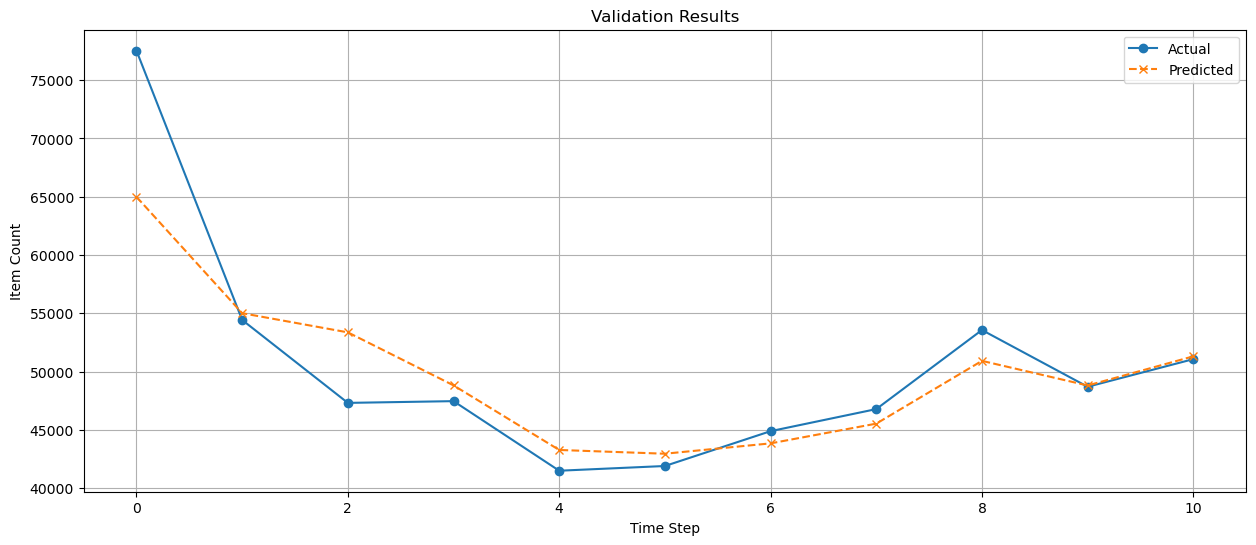

In [9]:
transformed_train, lam = arima_analysis(train_series)
order = auto_select_arima_order(transformed_train)
model = fit_arima(transformed_train, order)
save_model(model, lam)


actual, forecast_transformed = forecast_update(model, val_series, lam)

forecast = inverse_transform(forecast_transformed, lam)

rmse = np.sqrt(mean_squared_error(actual, forecast))
print(f'Validation RMSE: {rmse:.2f}')

visualize_results(actual, forecast)

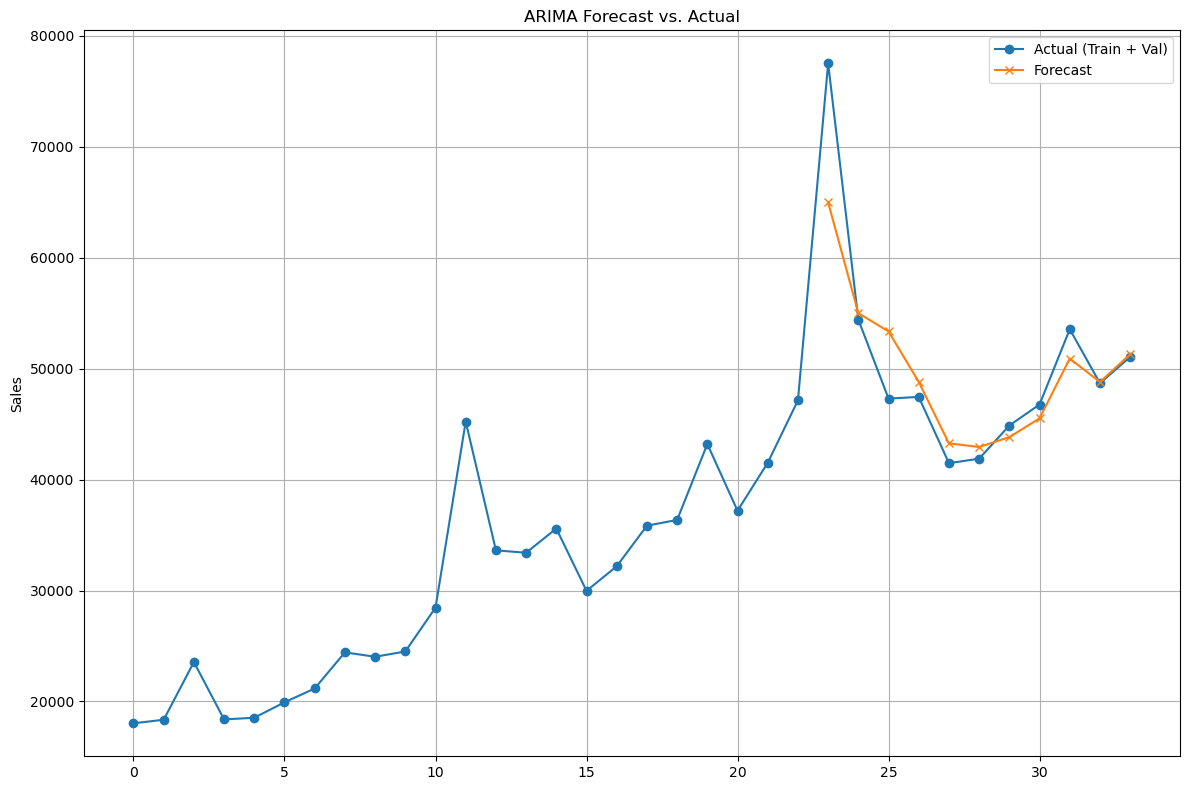

In [10]:
full_series = pd.concat([train_series, val_series], axis=0)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True)

axes.plot(full_series.index, full_series.values, label='Actual (Train + Val)', marker='o')
axes.plot(val_series.index, forecast, label='Forecast', marker='x')
axes.set_title('ARIMA Forecast vs. Actual')
axes.set_ylabel('Sales')
axes.legend()
axes.grid(True)

plt.tight_layout()
plt.show()

ADF Statistic: -1.1243
p-value: 0.7053
ADF Statistic: -1.1562
p-value: 0.6921
Suggested differencing order (d): 1


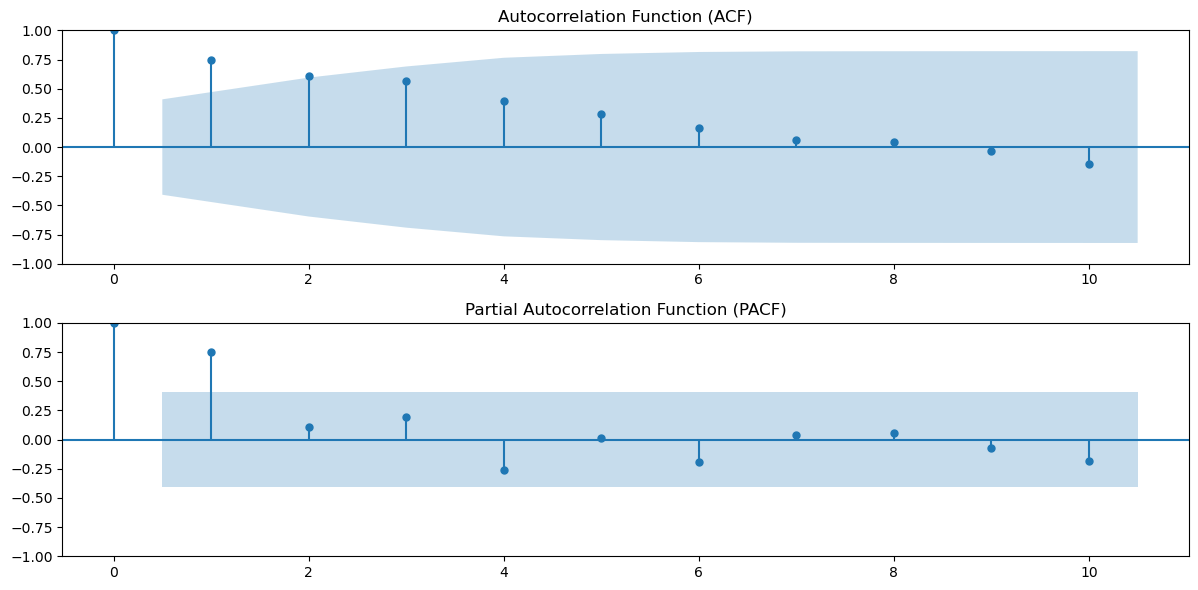

After differencing order (d): 1, p_value : 6.491876748662523e-08


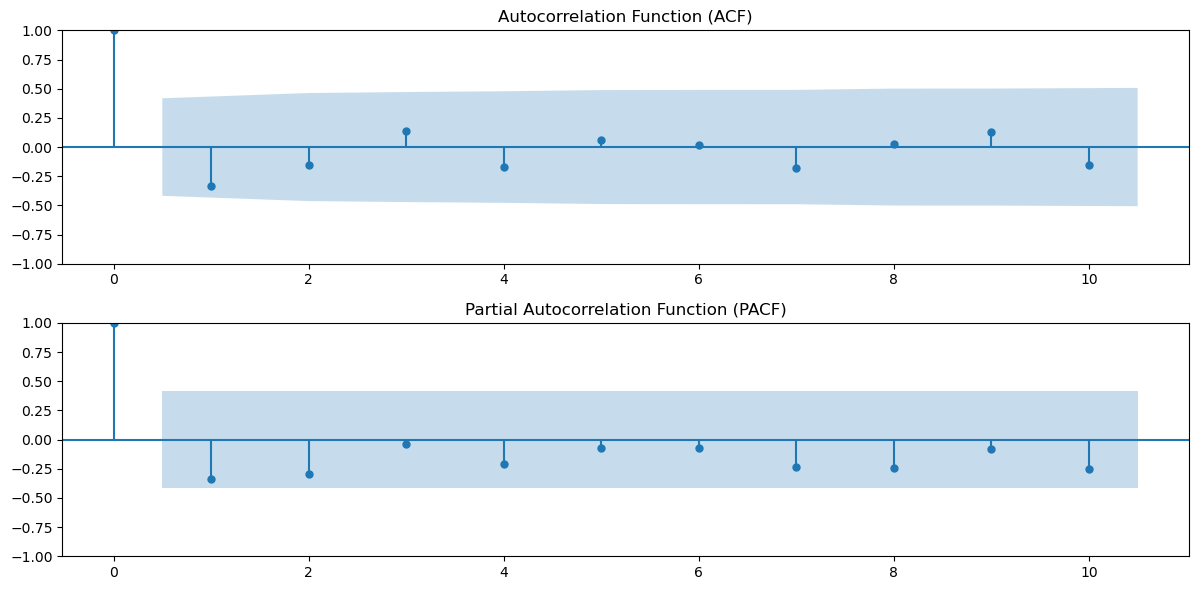

Manual Order Selection Guide:
1. Look at ACF/PACF plots:
   - PACF cuts off at lag p : AR(p)
   - ACF cuts off at lag q : MA(q)
2. Use d=1 based on ADF test


In [11]:
transformed_train, lam = arima_analysis(train_series)
order = manual_order_selection(transformed_train)

Model saved to arima_model.pkl
Validation RMSE: 4097.23


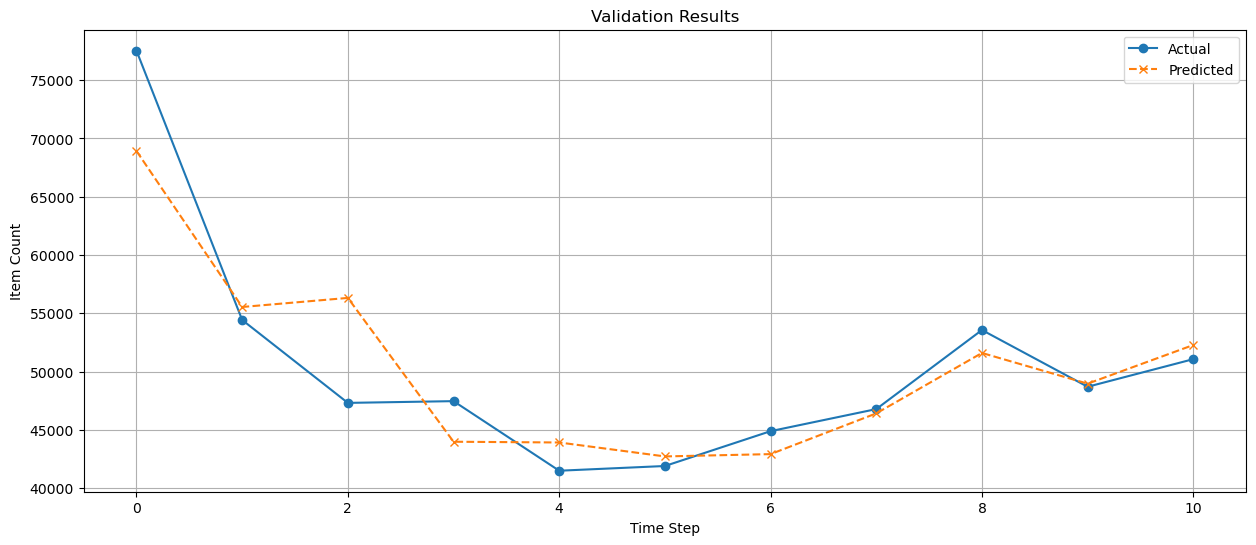

In [12]:
model = fit_arima(transformed_train, order)
save_model(model, lam)


actual, forecast_transformed = forecast_update(model, val_series, lam)

forecast = inverse_transform(forecast_transformed, lam)

rmse = np.sqrt(mean_squared_error(actual, forecast))
print(f'Validation RMSE: {rmse:.2f}')

visualize_results(actual, forecast)

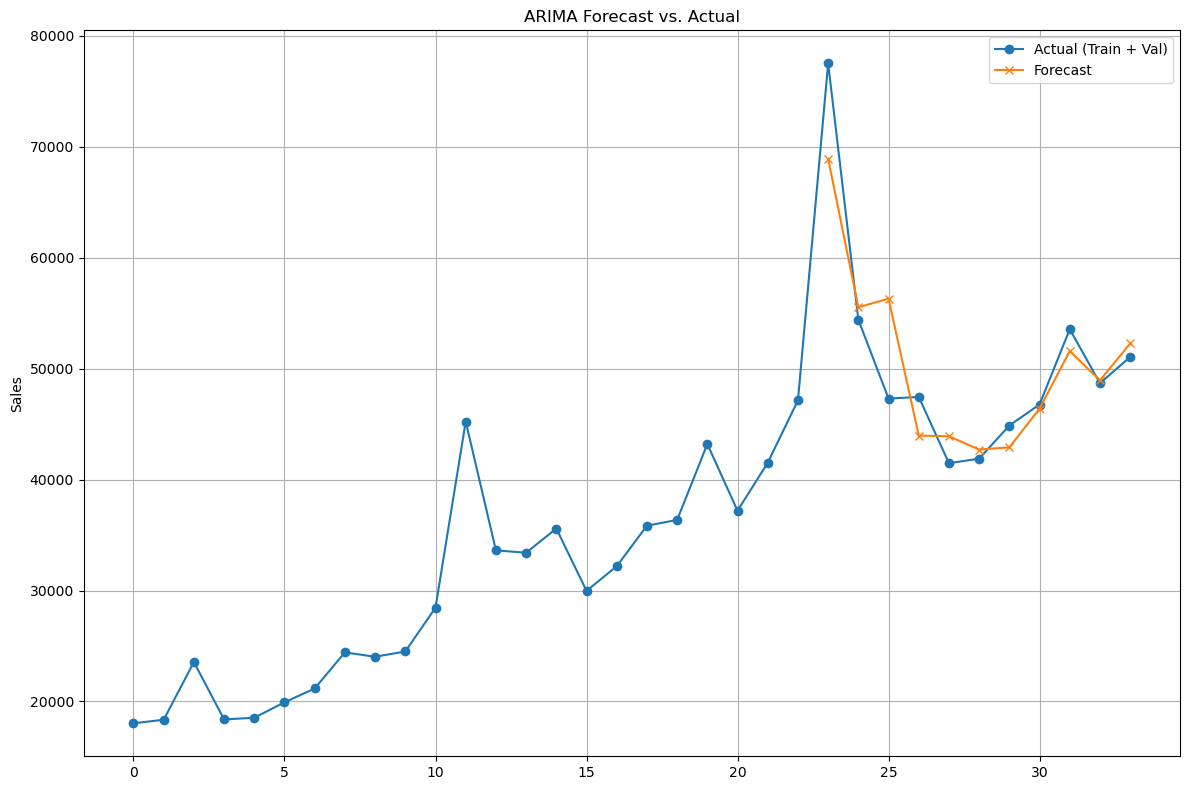

In [13]:
full_series = pd.concat([train_series, val_series], axis=0)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8), sharex=True)

axes.plot(full_series.index, full_series.values, label='Actual (Train + Val)', marker='o')
axes.plot(val_series.index, forecast, label='Forecast', marker='x')
axes.set_title('ARIMA Forecast vs. Actual')
axes.set_ylabel('Sales')
axes.legend()
axes.grid(True)

plt.tight_layout()
plt.show()

In [14]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [15]:
item_categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [16]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [17]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [18]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1
1,03.01.2013,0,25,2552,899.000000,1
2,05.01.2013,0,25,2552,899.000000,-1
3,06.01.2013,0,25,2554,1709.050049,1
4,15.01.2013,0,25,2555,1099.000000,1
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1
2935845,09.10.2015,33,25,7460,299.000000,1
2935846,14.10.2015,33,25,7459,349.000000,1
2935847,22.10.2015,33,25,7440,299.000000,1


In [19]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-01-02,0,59,22154,999.0,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
10,2013-01-03,0,25,2574,399.0,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
11,2013-01-05,0,25,2574,399.0,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
12,2013-01-07,0,25,2574,399.0,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
13,2013-01-08,0,25,2574,399.0,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.0,1,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935845,2015-10-09,33,25,7460,299.0,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.0,1,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.0,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3
